# Tutorial: dynamic GRN inference from SHARE-seq dataset of mouse skin
# Step 1: trajectory inference with STREAM
This is a [Dictys](https://github.com/pinellolab/dictys) tutorial to reconstruct and analyze dynamic GRNs from the SHARE-seq dataset of mouse skin. This notebook is step 1 that infers the trajectory and pseudo-time of cell differentiation with STREAM and exports trajectory data to individual files for further processing by Dictys in main2.ipynb.

This is the same dataset as the one used in the paper, but you should not expect it reproduce the figures. This is because the tutorial aims to demonstrate the reconstruction of dynamic GRNs not provided in the paper. Use tutorial [analysis-skin](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/analysis-skin) if you want to redraw the figures.

**You need to run this notebook in STREAM's own anaconda environment**. You can install STREAM [here](https://github.com/pinellolab/STREAM). This notebook is based on [its tutorial](https://nbviewer.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true).

Any trajectory inference software can be used as long as it outputs the trajectory (as nodes and edges) and each cell's location on the trajectory (either as edge & location on the trajectory, or as distance to each node). See different constructors of `dictys.traj.trajectory` and `dictys.traj.point`. Only tree-shaped trajectory is accepted.

If you face any issues or need any assistance, see [FAQ](https://github.com/pinellolab/dictys#faq) and [Issues](https://github.com/pinellolab/dictys#issues).


## Configuration
Note: this step may take **one hour or longer** depending on your network speed.

In [1]:
# Removes CPU usage limit by some jupyter versions
import os
os.environ['KMP_AFFINITY'] = ''
# Download network data from zenodo
# Replace *dictys* with your own environment name for Dictys
!. activate dictys && cd .. && dictys_helper repodown.sh zenodo full-skin.tar.xz


## Load data

In [2]:
import numpy as np
import pandas as pd
import anndata as ad

# Input file path of low-dimensional coordinates for cells to infer trajectory
fname='../data/coord_rna.tsv.gz'

# Load cell coordindates
d=pd.read_csv(fname,header=0,index_col=0,sep='\t')
ns=d.shape[0]

# Load cell subset information
d['label']=None
with open('../data/subsets.txt','r') as f:
	subsets_name=[x.strip() for x in f.readlines()]
cells=set(d.index)
for subset in subsets_name:
	with open(f'../data/subsets/{subset}/names_rna.txt','r') as f:
		c=[x.strip() for x in f.readlines()]
	c=set(c)&cells
	d.loc[set(c)&cells,'label']=subset

# Construct adata only with coordinates and subsets
adata=ad.AnnData(np.array([]).reshape(ns,0))
adata.obs = d[['label']].copy()
adata.obsm['X_dr'] = d[['x','y']].values.copy()


## Trajectory inference

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "128"
from tempfile import TemporaryDirectory
import stream as st

# Parameters for STREAM
ka1={'epg_alpha':0.05,'epg_mu':0.01,'epg_lambda':0.1,'epg_trimmingradius':2}
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

~/.conda/envs/stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Saving results in: /tmp/tmpjfnmin2h
No initial structure is seeded
Learning elastic principal graph...
[1]
 "Generating the initial configuration"


[1]
 "Creating a chain in the 1st PC with 2 nodes"


[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "The elastic matrix is being used. Edge configuration will be ignored"


[1]
 "Computing EPG with 50 nodes on 6436 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
2
 
3
 
4
 
5
 
6
 
7
 
8
 
9
 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
0.5861
	
50
	
49
	
46
	
1
	
0
	
0
	
0.267
	
0.2634
	
0.9726
	
0.973
	
0.3076
	
0.0115
	
0.5748
	
28.74
	
0




~/.conda/envs/stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


26.423 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


## Trajectory visualization
Use this step to determine whether you are happy with the inferred trajectory, and rerun the previous step with different parameters as needed.

Note: **record cell type/developmental stage annotations** of the nodes (S0, ...) for future dynamic GRN analyses.

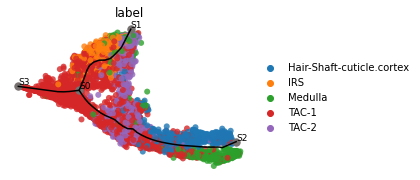

In [4]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['label'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In this trajectory, S3 (TAC-1) is the starting point of differentiation and S1, S2 are two terminal states.

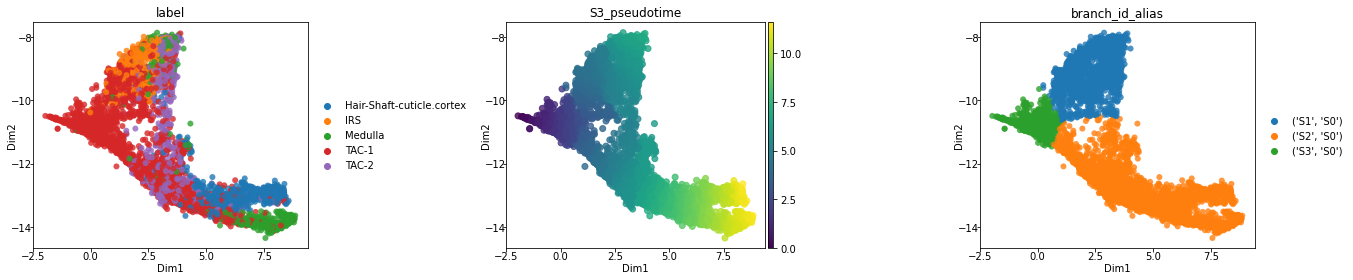

In [5]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['label','S3_pseudotime','branch_id_alias'])


## Output trajectory

In [6]:
!mkdir -p ../tmp

dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[d.index,x+'_pseudotime'].values for x in dimnodes]).T
ndict=dict(zip(dimnodes,range(len(dimnodes))))

# The branch each cell is on
branch=np.array([sorted([ndict[y] for y in x]) for x in list(adata.obs.loc[d.index,'branch_id_alias'])])
branch=pd.DataFrame(branch,index=d.index)
branch.to_csv('../tmp/branch.tsv.gz',header=False,index=False,sep='\t')

# Edge existence between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv('../tmp/edge.tsv.gz',header=False,index=False,sep='\t')

# Distance from each cell to all nodes
dist=pd.DataFrame(dist,index=d.index,columns=dimnodes)
dist.to_csv('../tmp/dist.tsv.gz',header=True,index=True,sep='\t')


## Now move on to [main2.ipynb](main2.ipynb) in Dictys' environment